In [69]:
import torch
import torchvision.models as models
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import cv2
import numpy as np
import random
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Build mini AlexNet model from scratch, replace Flaten with Global Average Pooling

In [71]:
num_classes = 2

class AlexNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(AlexNet, self).__init__()
        # Convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(128, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d(1)

        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [72]:
model = AlexNet(3, num_classes).to(device)

In [73]:
from torchinfo import summary
summary(model, (1, 3, 227, 227))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 57, 57]           1,792
│    └─ReLU: 2-2                         [1, 64, 57, 57]           --
│    └─MaxPool2d: 2-3                    [1, 64, 28, 28]           --
│    └─Conv2d: 2-4                       [1, 128, 28, 28]          73,856
│    └─ReLU: 2-5                         [1, 128, 28, 28]          --
│    └─MaxPool2d: 2-6                    [1, 128, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 512, 13, 13]          590,336
│    └─ReLU: 2-8                         [1, 512, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 512, 13, 13]          2,359,808
│    └─ReLU: 2-10                        [1, 512, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

In [74]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=10**-6)

In [75]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = ImageFolder(root='augmented_data/train', transform=transform)
val_data = ImageFolder(root='augmented_data/val', transform=transform)
test_data = ImageFolder(root='augmented_data/test', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

Epoch 1/100, Train Loss: 0.6934, Val Loss: 0.6919
Epoch 2/100, Train Loss: 0.6934, Val Loss: 0.6919
Epoch 3/100, Train Loss: 0.6934, Val Loss: 0.6918
Epoch 4/100, Train Loss: 0.6932, Val Loss: 0.6916
Epoch 5/100, Train Loss: 0.6933, Val Loss: 0.6916
Epoch 6/100, Train Loss: 0.6928, Val Loss: 0.6915
Epoch 7/100, Train Loss: 0.6929, Val Loss: 0.6913
Epoch 8/100, Train Loss: 0.6926, Val Loss: 0.6912
Epoch 9/100, Train Loss: 0.6927, Val Loss: 0.6911
Epoch 10/100, Train Loss: 0.6923, Val Loss: 0.6910
Epoch 11/100, Train Loss: 0.6922, Val Loss: 0.6909
Epoch 12/100, Train Loss: 0.6918, Val Loss: 0.6908
Epoch 13/100, Train Loss: 0.6919, Val Loss: 0.6906
Epoch 14/100, Train Loss: 0.6918, Val Loss: 0.6905
Epoch 15/100, Train Loss: 0.6917, Val Loss: 0.6904
Epoch 16/100, Train Loss: 0.6913, Val Loss: 0.6903
Epoch 17/100, Train Loss: 0.6914, Val Loss: 0.6901
Epoch 18/100, Train Loss: 0.6915, Val Loss: 0.6900
Epoch 19/100, Train Loss: 0.6915, Val Loss: 0.6899
Epoch 20/100, Train Loss: 0.6910, Val Lo

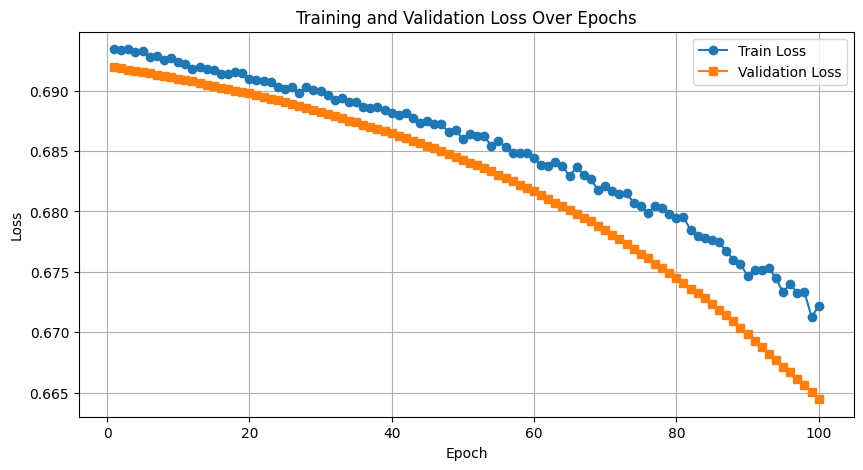

In [76]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='s')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

In [77]:
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
print(acc)
result = classification_report(y_true, y_pred)
print(result)


0.9
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       150
           1       0.92      0.87      0.90       150

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300



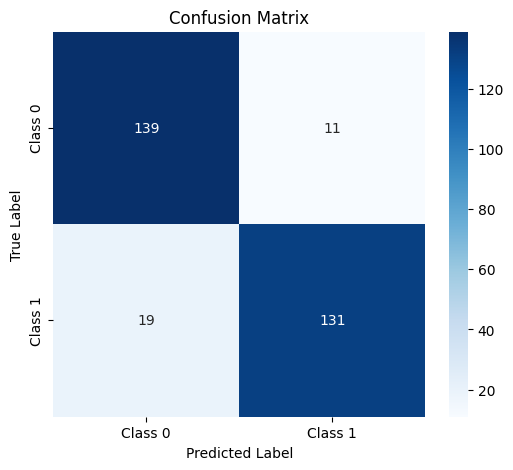

In [78]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()